# Truck Data Wrangler

Exploratory analysis of the dataset inside the `data` folder.

## Unifying the csv´s

First of all we will aggregate all csv data inside a single one. All the CSV files has these commons columns:

 - Timestamp (`timestamp timestamp`)
 - Longitudinal acceleration (`accel_x decimal (12, 6)`)
 - Lateral acceleration (`accel_y decimal (12, 6)`)
 - Vertical acceleration (`accel_z decimal (12, 6)`)
 - Roll rotation (`gyro_roll decimal (12, 6)`)
 - Pitch rotation (`gyro_pitch decimal (12, 6)`)
 - Yaw rotation (`gyro_yaw decimal (12, 6)`)
 - Label (`label integer`)

And we will create another one to identify from which file the rows are coming from:

 - Event type (`event_type string`)
 
Altought this is not an scalable approach, I will use pandas just for the sake of this specific dataset analysis.

In [1]:
import pandas as pd

data_files = {
    'aggressive_bump_1550163148318484.csv': 'agressive_bump',
    'aggressive_longitudinal_acceleration_1549653321089461.csv': 'aggressive_longitudinal_acceleration',
    'aggressive_turn_1549625320507325.csv': 'aggressive_turn',
    'normal_longitudinal_acceleration_1549908723215048.csv': 'normal_longitudinal_acceleration',
    'normal_mixed_1549901031015048.csv': 'normal_mixed',
    'normal_mixed_1550054269957615.csv': 'normal_mixed',
    'normal_turn_1549626293857325.csv': 'normal_turn'
}

read_frames = []

for data_file, event_type in data_files.items():
    tmp_df = pd.read_csv('raw_data/' + data_file)
    tmp_df['event_type'] = event_type
    tmp_df = tmp_df[['event_type', 'label', 'timestamp', 'accel_x', 'accel_y', 'accel_z', 'gyro_roll', 'gyro_pitch', 'gyro_yaw']]
    read_frames.append(tmp_df)

df = pd.concat(read_frames)
df.to_csv('data/unified.csv')
df.shape

(81435, 9)

# Using Spark to wrangle the data

After creating the Spark session, we will load the `data/unified.csv`.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Truck Data Wrangler").getOrCreate()
spark

## Scalable strategy to unify the csv's

Below we will use the Spark itself to read all raw csv files and unify inside a single Data Frame.

**Important note:** we will assume always a default pattern of file name/content. The name suffix should be the event type using underscore to separate the event type and the unix timestamp (used to give some reference of the file version) `{event_type}_{unix_timestamp}.csv`

In [3]:
from batch.etl import unify_separate_event_files

unified_df = unify_separate_event_files(spark)

unified_df.describe().show()

+-------+---------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|     event_type|              label|           timestamp|            accel_x|             accel_y|             accel_z|           gyro_roll|          gyro_pitch|            gyro_yaw|
+-------+---------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|          81435|              81435|               81435|              81435|               81435|               81435|               81435|               81435|               81435|
|   mean|           null|0.15940320501013078|1.549864321579461E15|0.03282746487196292| 0.06452783855356337|   0.750974734304008|-3.82616469040609...|-2.62407542360109...|-0.00643768599137...|
| stddev|           null| 0.366053914978

## Average acceleration by event type and label

To calculate the average acceleration, grouping by event type and label, we will first read the unified.csv and create a SQL table from it:

In [3]:
from pyspark.sql.types import *

csvSchema = StructType([
    StructField("c0", IntegerType(), True),
    StructField("event_type", StringType(), False),
    StructField("label", StringType(), False),
    StructField("timestamp", LongType(), False),
    StructField("accel_x", DoubleType(), False),
    StructField("accel_y", DoubleType(), False),
    StructField("accel_z", DoubleType(), False),
    StructField("gyro_roll", DoubleType(), False),
    StructField("gyro_pitch", DoubleType(), False),
    StructField("gyro_yaw", DoubleType(), False)
])

truck_events_df = spark.read.schema(csvSchema).csv('data/unified.csv', header=True)
truck_events_df.createOrReplaceTempView("truck_events")

After creating the SQL view, the following query will give us the grouped results we want to analyze:

In [4]:
spark.sql("""
SELECT 
    event_type, 
    label, 
    AVG(accel_x) AS avg_accel_x,
    AVG(accel_y) AS avg_accel_y,
    AVG(accel_z) AS avg_accel_z
FROM 
    truck_events 
GROUP BY
    event_type, label
ORDER BY
    event_type, label
""").toPandas()

,event_type,label,avg_accel_x,avg_accel_y,avg_accel_z
0,aggressive_longitudinal_acceleration,0,0.072664,0.059177,0.749448
1,aggressive_longitudinal_acceleration,1,0.011803,0.063492,0.749371
2,aggressive_turn,0,0.071153,0.077650,0.751435
3,aggressive_turn,1,0.051853,0.041711,0.751523
4,agressive_bump,0,0.013834,0.061374,0.749088
5,agressive_bump,1,-0.065852,0.032218,0.748155
6,normal_longitudinal_acceleration,0,0.026090,0.078436,0.751428
7,normal_mixed,0,0.026531,0.063761,0.752289
8,normal_turn,0,0.068144,0.070013,0.751433


## The maximum jerk timestamp

To calculate the maximum jerk timestamp, first of all, we have to calculate the jerk of the momentum.

Thus, to calculate the jerk we can do it with this simple equation:

`jerk = (𝑎2 − 𝑎1) / (𝑡2 − 𝑡1)`

Where:
 - 𝑎2 is the acceleration of the current sensor registry
 - 𝑎1 is the acceleration of the last sensor registry before the current
 - 𝑡2 is the timestamp of the current sensor registry
 - 𝑡1 is the timestamp of the last sensor registry before the current
 


In [5]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.window import Window

column_list = ["event_type","label"]
win_spec = Window.partitionBy([col(x) for x in column_list]).orderBy("timestamp")

jerk_truck_events_df = truck_events_df

columns_that_needs_latest_values = ['accel_x', 'accel_y', 'accel_z', 'timestamp']

for column_name in columns_that_needs_latest_values:
    jerk_truck_events_df = jerk_truck_events_df.withColumn("last_" + column_name, F.lag(col(column_name)).over(win_spec))

jerk_truck_events_df.toPandas().head()

,c0,event_type,label,timestamp,accel_x,accel_y,accel_z,gyro_roll,gyro_pitch,gyro_yaw,last_accel_x,last_accel_y,last_accel_z,last_timestamp
0,0,aggressive_longitudinal_acceleration,0,1549653321089461,0.051708,0.054382,0.749002,0.000225,0.000219,-0.000349,NaN,NaN,NaN,NaN
1,1,aggressive_longitudinal_acceleration,0,1549653321139461,0.052857,0.054382,0.748827,0.000225,0.000219,-0.000348,0.051708,0.054382,0.749002,1.549653e+15
2,2,aggressive_longitudinal_acceleration,0,1549653321189461,0.053432,0.057321,0.750231,0.000225,-0.000313,0.000184,0.052857,0.054382,0.748827,1.549653e+15
3,3,aggressive_longitudinal_acceleration,0,1549653321239461,0.052283,0.055852,0.748651,-0.000307,0.000219,0.000715,0.053432,0.057321,0.750231,1.549653e+15
4,4,aggressive_longitudinal_acceleration,0,1549653321289461,0.052283,0.057321,0.748827,-0.000307,0.000218,-0.000349,0.052283,0.055852,0.748651,1.549653e+15


Now that we have the latest values appended on the data frame, we need to create a last column with the jerk value calculated. We'll do it separately for each axis. This way we can more easily check for acceleration/breaks in the future.

In [6]:
# x axis
df = jerk_truck_events_df.withColumn(
    "jerk_x", 
    F.when(F.isnull(col("last_accel_x")), 0)
     .when(F.isnull(col("last_timestamp")), 0)
     .otherwise((col("accel_x") - col("last_accel_x")) / (col("timestamp") - col("last_timestamp")))
)

# y axis
df = df.withColumn(
    "jerk_y", 
    F.when(F.isnull(col("last_accel_y")), 0)
     .when(F.isnull(col("last_timestamp")), 0)
     .otherwise((col("accel_y") - col("last_accel_y")) / (col("timestamp") - col("last_timestamp")))
)

# z axis
df = df.withColumn(
    "jerk_z", 
    F.when(F.isnull(col("last_accel_z")), 0)
     .when(F.isnull(col("last_timestamp")), 0)
     .otherwise((col("accel_z") - col("last_accel_z")) / (col("timestamp") - col("last_timestamp")))
)

#df.toPandas().head()
df.describe("jerk_x").show()
df.describe("jerk_y").show()
df.describe("jerk_z").show()

+-------+--------------------+
|summary|              jerk_x|
+-------+--------------------+
|  count|               81435|
|   mean|1.441581488571492...|
| stddev|2.072853275067905...|
|    min|-4.46823395474348...|
|    max|3.535190045833587E-5|
+-------+--------------------+

+-------+--------------------+
|summary|              jerk_y|
+-------+--------------------+
|  count|               81435|
|   mean|3.967448509129019...|
| stddev|3.500832049863185...|
|    min|-7.15935850143432...|
|    max|6.377410769462586E-5|
+-------+--------------------+

+-------+--------------------+
|summary|              jerk_z|
+-------+--------------------+
|  count|               81435|
|   mean|7.190501408417495...|
| stddev|4.118166978012494...|
|    min|-9.21902656555175...|
|    max|1.050393342971801...|
+-------+--------------------+



#### Answering the question, the of the maximum jerk timestamp (per event_type/label):

In [7]:
df.createOrReplaceTempView("jerked_truck_events")

spark.sql("""
SELECT 
    event_type, 
    label, 
    from_unixtime(cast(((timestamp / 1000) / 1000) as bigint),'yyyy-MM-dd HH:mm:ss.SSS') AS timestamp,
    jerk_x
FROM 
    jerked_truck_events 
ORDER BY
    jerk_x DESC
LIMIT 1
""").toPandas()

,event_type,label,timestamp,jerk_x
0,agressive_bump,1,2019-02-14 16:56:16.000,0.000035


In [8]:

spark.sql("""
SELECT 
    event_type, 
    label, 
    from_unixtime(cast(((timestamp / 1000) / 1000) as bigint),'yyyy-MM-dd HH:mm:ss.SSS') AS timestamp,
    jerk_y
FROM 
    jerked_truck_events 
ORDER BY
    jerk_y DESC, event_type, label
LIMIT 1
""").toPandas()

,event_type,label,timestamp,jerk_y
0,agressive_bump,1,2019-02-14 16:54:13.000,0.000064


In [9]:

spark.sql("""
SELECT 
    event_type, 
    label, 
    from_unixtime(cast(((timestamp / 1000) / 1000) as bigint),'yyyy-MM-dd HH:mm:ss.SSS') AS timestamp,
    jerk_z
FROM 
    jerked_truck_events 
ORDER BY
    jerk_z DESC, event_type, label
LIMIT 1
""").toPandas()

,event_type,label,timestamp,jerk_z
0,agressive_bump,1,2019-02-14 16:52:32.000,0.000011


## Jerks of each separate axis

Below we will plot some graphics of the jerks values by the timestamp from `2019-02-14 16:52:00` until `2019-02-14 16:53:00`. We choosed this short interval because we have a high-frequency sensor here.

### The X-axis

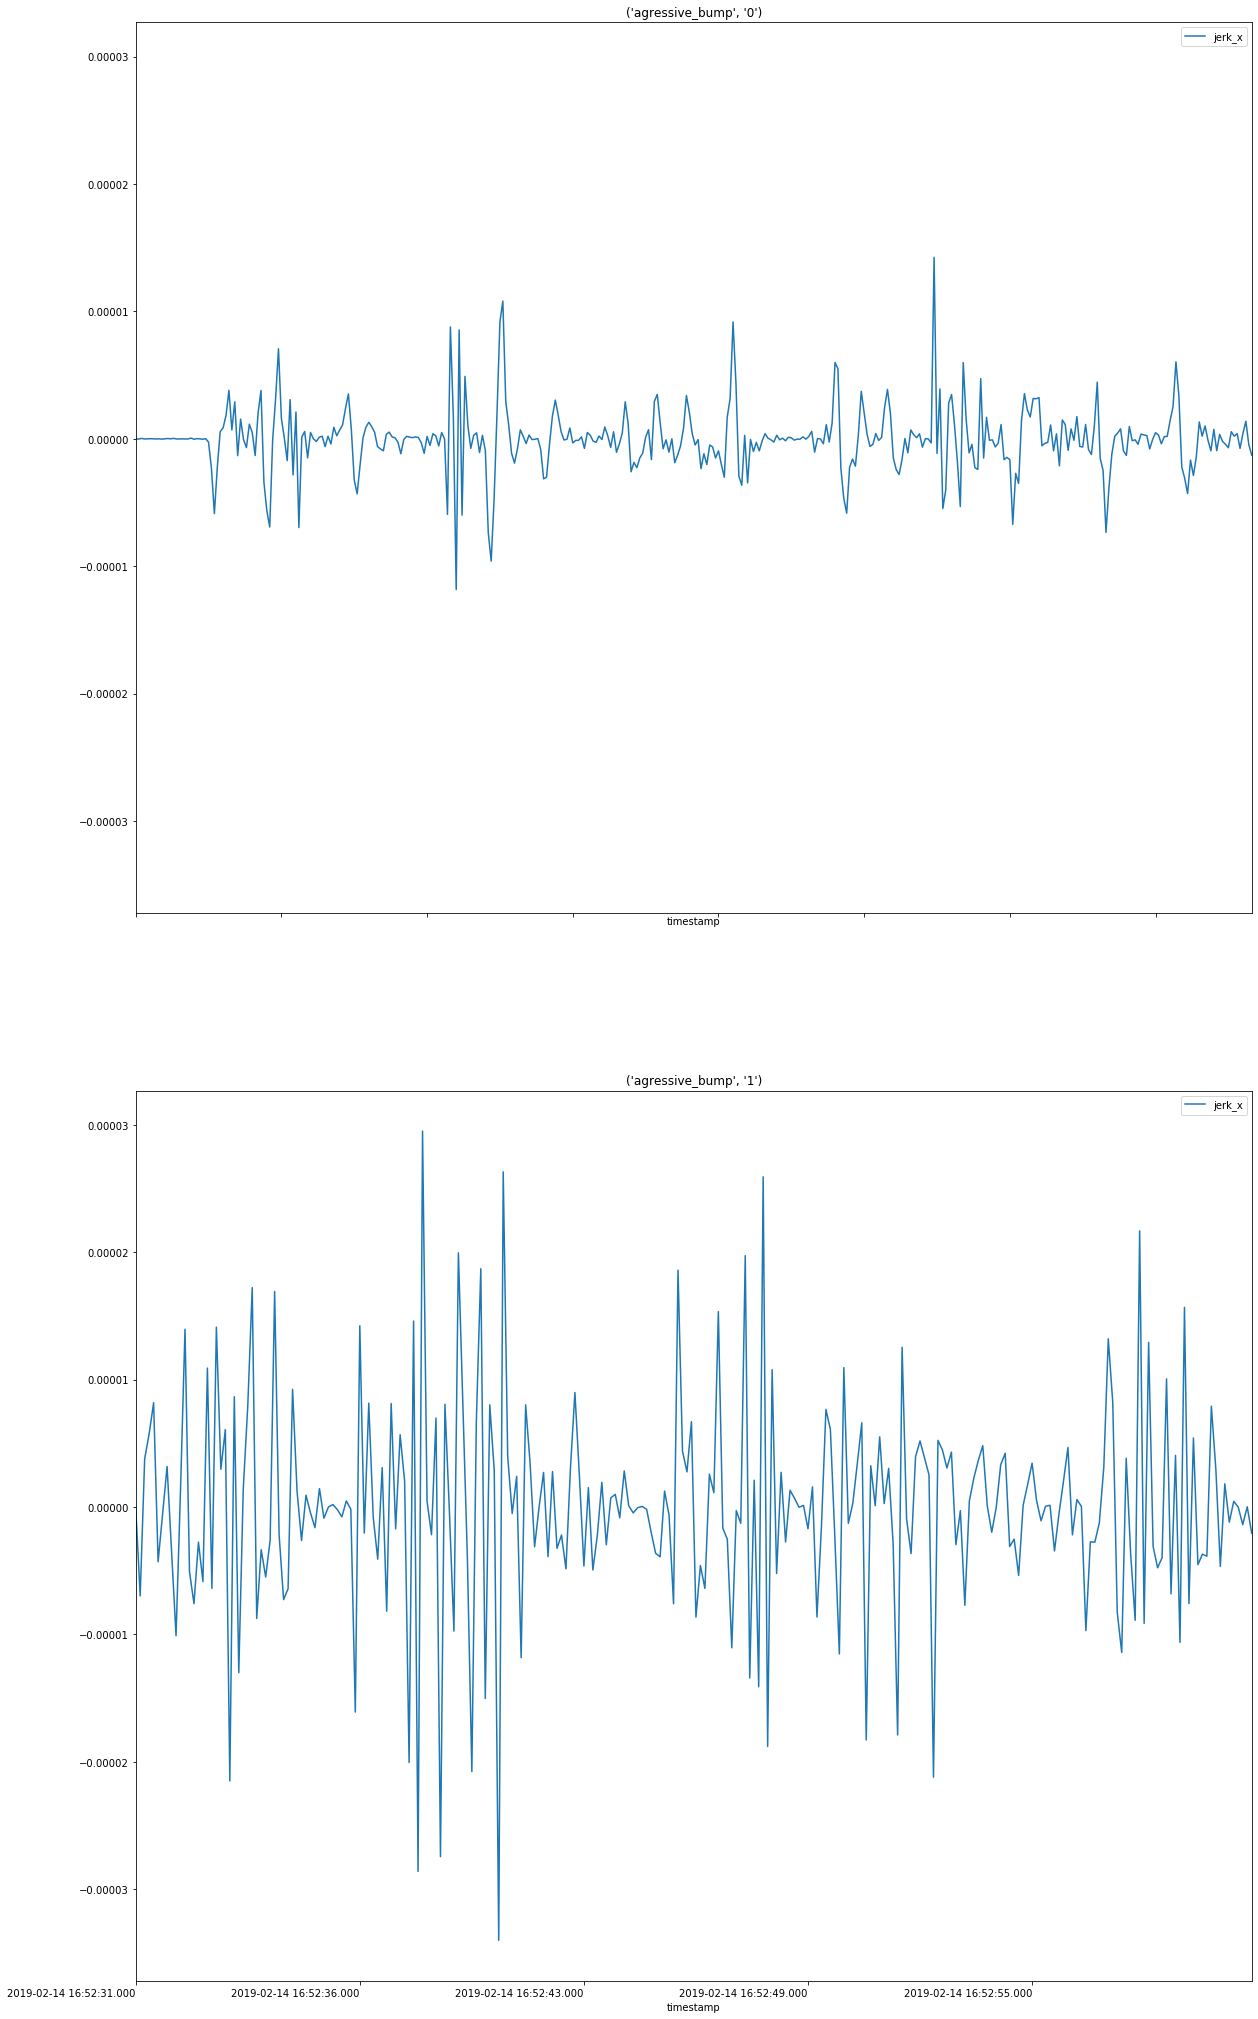

In [21]:
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.dates as mdates
from datetime import datetime

datetime_str = '2019/02/14 00:00:00'

datetime_start = datetime.timestamp(datetime.strptime('2019-02-14 16:52:00', '%Y-%m-%d %H:%M:%S'))
datetime_end = datetime.timestamp(datetime.strptime('2019-02-14 16:53:00', '%Y-%m-%d %H:%M:%S'))

df_jerk = spark.sql("""
SELECT 
    from_unixtime(cast(((timestamp / 1000) / 1000) as bigint),'yyyy-MM-dd HH:mm:ss.SSS') AS timestamp,
    event_type, 
    label,
    jerk_x,
    jerk_y,
    jerk_z
FROM 
    jerked_truck_events 
WHERE
    timestamp >= {} AND
    timestamp <= {}
ORDER BY
    jerked_truck_events.timestamp, event_type, label
""".format(datetime_start * 1000 * 1000, datetime_end * 1000 * 1000)).toPandas()

def show_subplots(grouped_df_jerk):
    ncols=1
    nrows = int(np.ceil(grouped_df_jerk.ngroups/ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40), sharey=True)
    
    fig.autofmt_xdate()

    for (key, ax) in zip(grouped_df_jerk.groups.keys(), axes.flatten()):
        ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d ')
        ax.set_title(key)
        grouped_df_jerk.get_group(key).plot(kind='line',ax=ax,x='timestamp')

    ax.legend(loc='best')
    plt.show()

grouped_df_jerk = df_jerk[['timestamp', 'event_type', 'label', 'jerk_x']].groupby(['event_type', 'label'])

show_subplots(grouped_df_jerk)

### The Y-axis

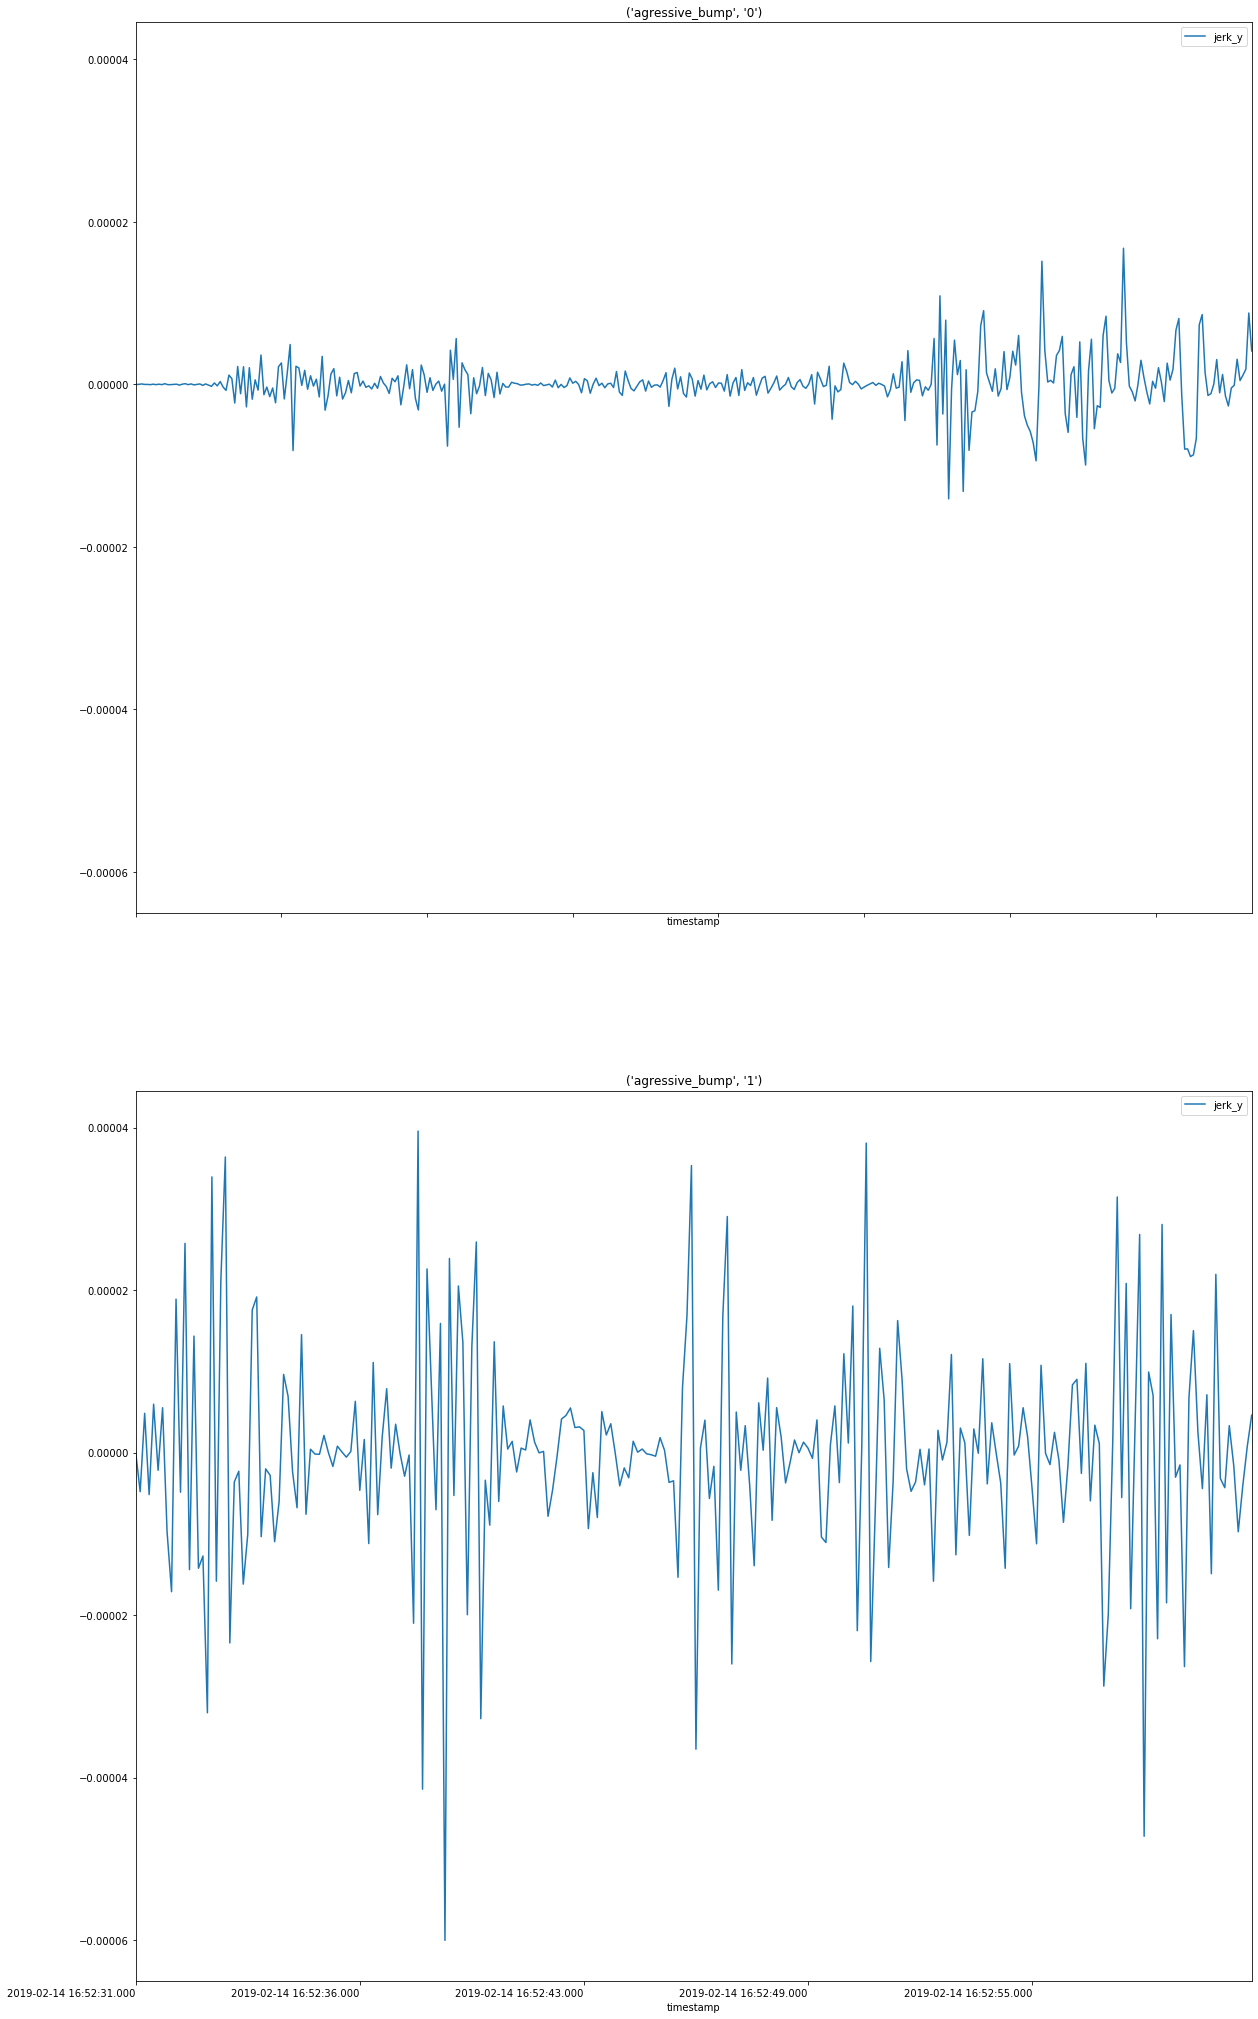

In [22]:
grouped_df_jerk = df_jerk[['timestamp', 'event_type', 'label', 'jerk_y']].groupby(['event_type', 'label'])

show_subplots(grouped_df_jerk)

### The Z-axis

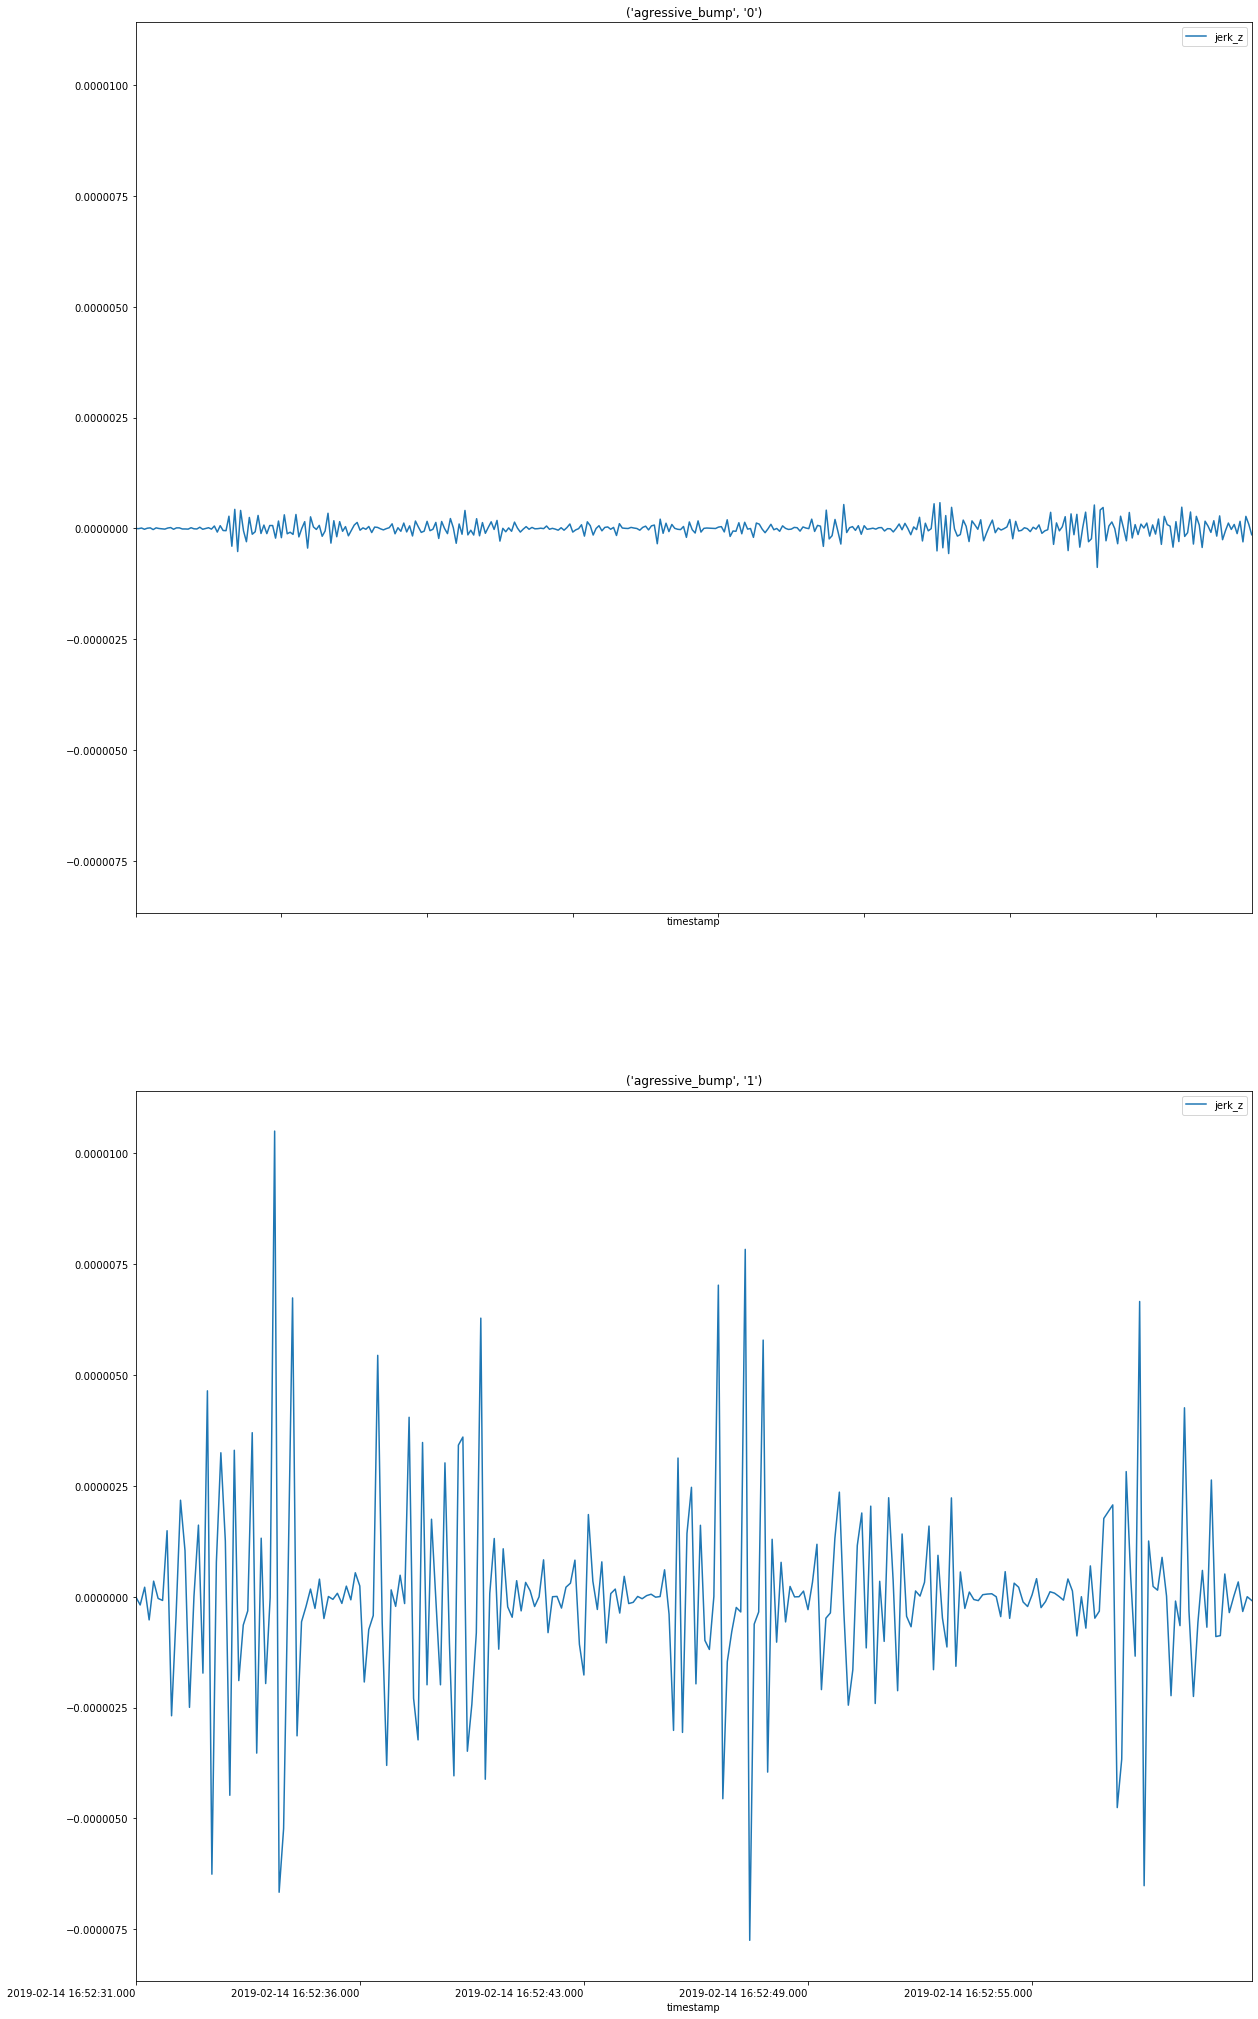

In [23]:
grouped_df_jerk = df_jerk[['timestamp', 'event_type', 'label', 'jerk_z']].groupby(['event_type', 'label'])

show_subplots(grouped_df_jerk)

## Activity timestamps

Below we have the max/min window of data from the truck sensors

In [17]:
spark.sql("""
SELECT 
    from_unixtime(cast(((MIN(timestamp) / 1000) / 1000) as bigint),'yyyy-MM-dd HH:mm:ss.SSS') AS min_timestamp,
    from_unixtime(cast(((MAX(timestamp) / 1000) / 1000) as bigint),'yyyy-MM-dd HH:mm:ss.SSS') AS max_timestamp
FROM 
    jerked_truck_events 
""").toPandas()

,min_timestamp,max_timestamp
0,2019-02-08 11:28:40.000,2019-02-14 17:02:32.000
